In [1]:
pip install transformers pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 735.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
#aset_train.rename_column_('label', 'labels')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
#dataset_test.rename_column_('label', 'labels')
test_df=pd.DataFrame(dataset_test)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [6]:
# Load the tokenizer for BART
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")

In [7]:
# Define a custom dataset class
class IMDbDataset(Dataset):
    def __init__(self, tokenizer, dataframe, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['text'])
        label = int(self.data.iloc[idx]['label'])
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label)
        }


In [8]:
# Create data loaders
train_dataset = IMDbDataset(tokenizer, train_df)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [9]:
val_dataset = IMDbDataset(tokenizer, val_df)
val_loader = DataLoader(val_dataset, batch_size=8)

In [10]:
test_dataset = IMDbDataset(tokenizer, test_df)
test_loader = DataLoader(test_dataset, batch_size=8)

In [11]:
# Load the BART model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

In [12]:
# Define optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): Layer

In [14]:
import time

In [15]:
%%time

start_time = time.time()  # Record the start time
for epoch in range(3):  # Change the number of epochs as needed
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
end_time = time.time()
training_time = end_time - start_time  # Calculate the training time
print(f"Training time: {training_time:.2f} seconds")

Training time: 6671.24 seconds
CPU times: user 1h 14min 37s, sys: 37min 7s, total: 1h 51min 44s
Wall time: 1h 51min 11s


In [16]:
# Evaluation on train data
model.eval()
train_predictions = []

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
with torch.no_grad():
    for batch in train_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        train_predictions.extend(preds.cpu().numpy())
        train_labels = np.array(train_df['label'])

In [19]:
TRAIN_accuracy = accuracy_score(train_labels, train_predictions)
TRAIN_precision = precision_score(train_labels, train_predictions)
TRAIN_recall = recall_score(train_labels, train_predictions)
TRAIN_f1 = f1_score(train_labels, train_predictions)

print("Train Accuracy:", TRAIN_accuracy)
print("Train Precision:", TRAIN_precision)
print("Train Recall:", TRAIN_recall)
print("Train F1 Score:", TRAIN_f1)

Train Accuracy: 0.5012
Train Precision: 0.5033019283261425
Train Recall: 0.505930253142149
Train F1 Score: 0.5046126682851468


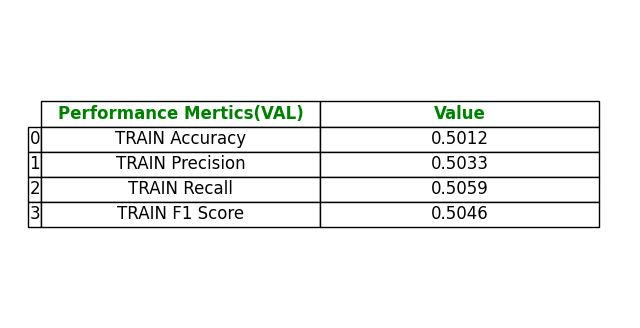

In [20]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Sample values
evaluation_metrics = ['TRAIN Accuracy', 'TRAIN Precision', 'TRAIN Recall', 'TRAIN F1 Score']
values = [format(TRAIN_accuracy, ".4f"),format(TRAIN_precision, ".4f") , format(TRAIN_recall, ".4f"), format(TRAIN_f1, ".4f"),]

# Create a DataFrame to store the evaluation metrics
import pandas as pd
data = {'Performance Mertics(VAL)': evaluation_metrics, 'Value': values}
df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table without borders and headers
tab = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Change color of headers and make them bold
for key, cell in tab.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='green')

plt.savefig('evaluation_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Evaluation on validation data
model.eval()
val_predictions = []

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
with torch.no_grad():
    for batch in val_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_predictions.extend(preds.cpu().numpy())
        val_labels = np.array(val_df['label'])


In [24]:
VAL_accuracy = accuracy_score(val_labels, val_predictions)
VAL_precision = precision_score(val_labels, val_predictions)
VAL_recall = recall_score(val_labels, val_predictions)
VAL_f1 = f1_score(val_labels, val_predictions)

print("Validation Accuracy:", VAL_accuracy)
print("Validation Precision:", VAL_precision)
print("Validation Recall:", VAL_recall)
print("Validation F1 Score:", VAL_f1)

Validation Accuracy: 0.9196
Validation Precision: 0.9126133553173948
Validation Recall: 0.9209650582362728
Validation F1 Score: 0.9167701863354037


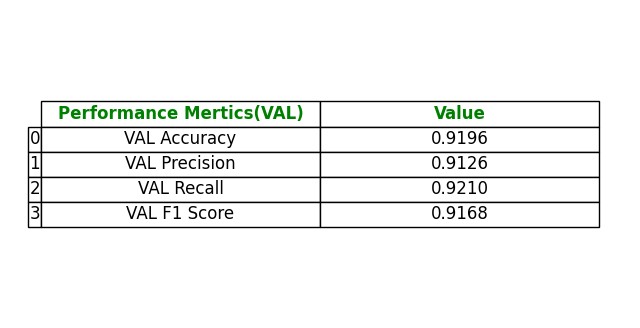

In [25]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Sample values
evaluation_metrics = ['VAL Accuracy', 'VAL Precision', 'VAL Recall', 'VAL F1 Score']
values = [format(VAL_accuracy, ".4f"),format(VAL_precision, ".4f") , format(VAL_recall, ".4f"), format(VAL_f1, ".4f"),]

# Create a DataFrame to store the evaluation metrics
import pandas as pd
data = {'Performance Mertics(VAL)': evaluation_metrics, 'Value': values}
df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table without borders and headers
tab = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Change color of headers and make them bold
for key, cell in tab.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='green')

plt.savefig('evaluation_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Evaluation on test data
test_predictions = []

In [27]:
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        test_labels = np.array(test_df['label'])

In [30]:
TEST_accuracy= accuracy_score(test_labels, test_predictions)
TEST_precision = precision_score(test_labels, test_predictions)
TEST_recall = recall_score(test_labels, test_predictions)
TEST_f1 = f1_score(test_labels, test_predictions)

print("TEST_accuracy:", train_accuracy)
print("TEST_precision:", train_precision)
print("TEST_recall:", train_recall)
print("TEST_f1:", train_f1)


TEST_accuracy: 0.9206
TEST_precision: 0.9189576858713842
TEST_recall: 0.92256
TEST_f1: 0.9207553195736358


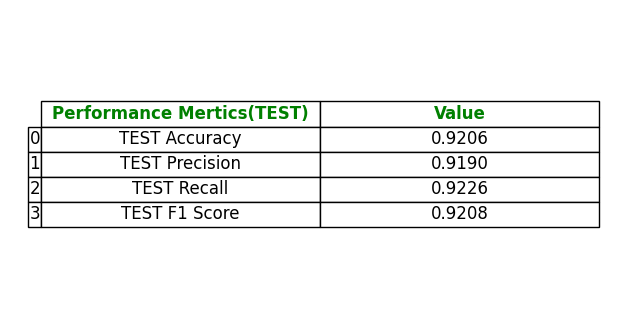

In [31]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Sample values
evaluation_metrics = ['TEST Accuracy', 'TEST Precision', 'TEST Recall', 'TEST F1 Score']
values = [format(TEST_accuracy, ".4f"),format(TEST_precision, ".4f") , format(TEST_recall, ".4f"), format(TEST_f1, ".4f"),]

# Create a DataFrame to store the evaluation metrics
import pandas as pd
data = {'Performance Mertics(TEST)': evaluation_metrics, 'Value': values}
df = pd.DataFrame(data)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table without borders and headers
tab = table(ax, df, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Change color of headers and make them bold
for key, cell in tab.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='green')

plt.savefig('evaluation_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()

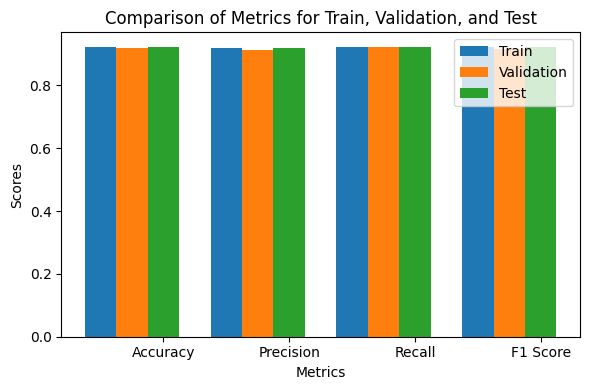

In [32]:
# Metrics for Train and Validation
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
train_metrics = [train_accuracy, train_precision, train_recall, train_f1]
val_metrics = [VAL_accuracy, VAL_precision, VAL_recall, VAL_f1]
test_metrics = [TEST_accuracy, TEST_precision, TEST_recall, TEST_f1]
# Number of metrics
num_metrics = len(metrics_names)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.25

# Set positions for the bars
positions_train = range(num_metrics)
positions_val = [pos + bar_width for pos in positions_train]
positions_test = [pos + bar_width for pos in positions_val]

# Plot bars for Train, Validation, and Test
ax.bar(positions_train, train_metrics, bar_width, label='Train')
ax.bar(positions_val, val_metrics, bar_width, label='Validation')
ax.bar(positions_test, test_metrics, bar_width, label='Test')

# Set labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Train, Validation, and Test')
ax.set_xticks([pos + bar_width for pos in positions_val])
ax.set_xticklabels(metrics_names)
ax.legend()

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [34]:
# Calculate TP, TN, FP, FN
conf_matrix = confusion_matrix(test_labels, test_predictions)
TEST_TP = conf_matrix[1, 1]
TEST_TN = conf_matrix[0, 0]
TEST_FP = conf_matrix[0, 1]
TEST_FN = conf_matrix[1, 0]

In [35]:
# Calculate AUC
test_probabilities = []

In [36]:
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**inputs)
        logits = outputs.logits
        test_probabilities.extend(logits.softmax(dim=1).cpu().numpy())

In [37]:
test_probabilities = np.array(test_probabilities)
TEST_AUC = roc_auc_score(test_labels, test_probabilities[:, 1])  # Assuming column 1 corresponds to positive class

print("TEST AUC:", TEST_AUC)


TEST AUC: 0.9755964672


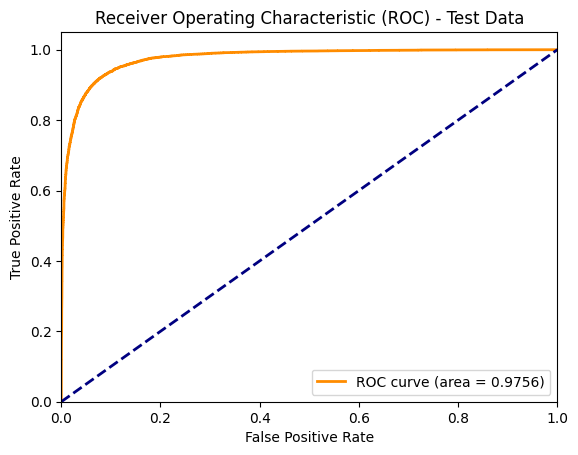

In [38]:
# ROC Curve for Test Dataset
fpr_test, tpr_test, _ = roc_curve(test_labels, test_probabilities[:, 1])

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % TEST_AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()




In [39]:
import seaborn as sns

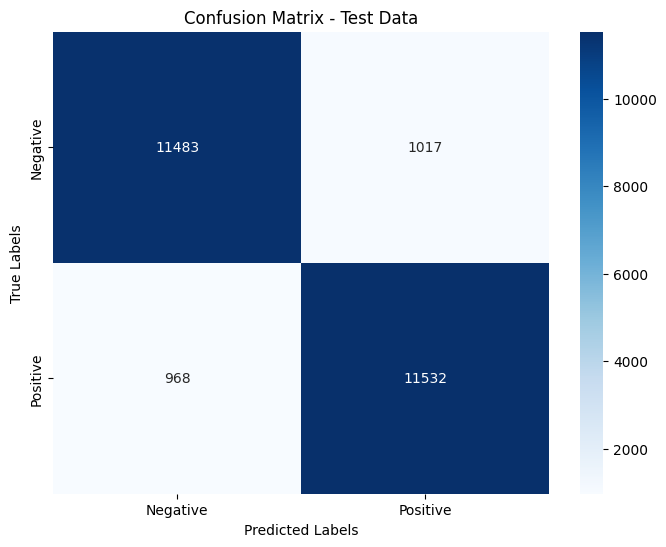

In [40]:
# Confusion Matrix for Test Dataset
conf_matrix_test = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [41]:
samples = [
    'Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience.',
    'The movie was great!',
    'Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience.',
    'Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage',
    'The movie was terrible...'
]

label_dict = {0: 'negative', 1: 'positive'}

with torch.no_grad():
    for idx, sample in enumerate(samples):
        encoding = tokenizer(sample, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in encoding.items() if k != 'labels'}
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        pred_label = label_dict[preds.item()]
        prob_scores = torch.nn.functional.softmax(logits, dim=1)
        prob_score_positive_class = prob_scores[:, 1].item()
        print('{} - Prediction: {}, Probability: {:.4f} - "{}"'.format(idx, pred_label, prob_score_positive_class, sample))


0 - Prediction: positive, Probability: 0.9972 - "Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience."
1 - Prediction: positive, Probability: 0.9956 - "The movie was great!"
2 - Prediction: negative, Probability: 0.0016 - "Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience."
3 - Prediction: negative, Probability: 0.0030 - "Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage"
4 - Prediction: negative, Probability: 0.0054 - "The movie was terrible..."
